In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)
 
# 切换到上一层目录
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print("切换后的目录：", parent_dir)

当前工作目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS\unit_test
切换后的目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS


In [2]:
import pandas as pd
import QuantLib as ql
from devlib.market.curves.overnight_index_curves import Sofr, Estr
from devlib.market.curves.credit_curve_generator import MarketDataCreditCurve, CdsConfig
from devlib.utils.ql_date_utils import ql_date_str
from devlib.utils.cds_utils import calendar_5u

In [3]:
from nemesis.utils import *
from nemesis.products.rates import *
from nemesis.products.credit import *

####################################################################
#  NEMESIS ALPHA Version 0.1.0 - This build: 24 Jan 2025 at 10:42 #
####################################################################



### Build QuantLib IR Curve

In [4]:
today = ql.Date(1,11,2024)
ql.Settings.instance().evaluationDate = today

mkt_file_path = './unit_test/data/ICVS531_curve_data_20241101.xlsx'
swap_mkt_data = pd.read_excel(mkt_file_path, sheet_name='swap')
discount_curve = Sofr(today, swap_mkt_data=swap_mkt_data)

value_dt = Date(1,11,2024)
ois_curve = QLCurve(value_dt, discount_curve, dc_type=DayCountTypes.ACT_360, interp_type=InterpTypes.LINEAR_ZERO_RATES)

### Build QuantLib Credit Curve

In [5]:
entity = 'CHINAGOV'
mkt_file_path = './unit_test/data/credit_curve_data_20241101.xlsx'
cds_type = 'single_name'
cds_data = pd.read_excel(mkt_file_path, sheet_name=cds_type)

cds_config = CdsConfig(recovery_rate = 0.4,
                        daycount = ql.Actual360(),
                        calendar = calendar_5u())
daycount = ql.Actual360()

credit_curve = MarketDataCreditCurve(today, entity, cds_data, discount_curve, cds_type, cds_config, daycount)

In [6]:
pillar = credit_curve.curve.hazard_rate_series
dev_result = pd.DataFrame({
    "Date": [pd.Timestamp(ql_date_str(d)) for d in pillar.index],
    "Hazard Rate": pillar.values,
    "P(S)": [credit_curve.curve.survival_probability(d) for d in pillar.index]
})

### Build Credit Curve

In [7]:
cds_type = 'single_name'
mkt_file_path = './unit_test/data/credit_curve_data_20241101.xlsx'
cds_data = pd.read_excel(mkt_file_path, sheet_name=cds_type)

effective_dt = value_dt
settle_dt = effective_dt

cdss = [GeneralCDS(settle_dt, c["Tenor"], c["Spread"]/10000, notional=1e7) for _, c in cds_data.iterrows()]
recovery_rate = 0.40
issuer_curve = GeneralCDSCurve(value_dt, cdss, ois_curve, recovery_rate)

In [8]:
val_result = issuer_curve.print_table(formatted=False)

In [11]:
val_result

,Date,Hazard Rate,P(S)
0,2024-11-01,0.000000,1.000000
1,2025-06-20,0.005024,0.996782
2,2025-12-20,0.006219,0.993635
3,2026-12-20,0.008439,0.985170
4,2027-12-20,0.011047,0.974198
5,2028-12-20,0.013606,0.960815
6,2029-12-20,0.018727,0.942743
7,2031-12-20,0.021589,0.902363
8,2034-12-20,0.023913,0.839004


In [10]:
val_result.iloc[1:].set_index("Date") - dev_result.set_index("Date")

,Hazard Rate,P(S)
Date,,
2025-06-20,-1.065033e-08,6.811965e-09
2025-12-20,1.654991e-08,-1.568862e-09
2026-12-20,-2.230312e-09,6.722578e-10
2027-12-20,-1.188632e-09,1.838815e-09
2028-12-20,7.894468e-10,1.042401e-09
2029-12-20,-2.837779e-08,2.814734e-08
2031-12-20,-3.973869e-09,3.421305e-08
2034-12-20,-7.658497e-09,5.137288e-08


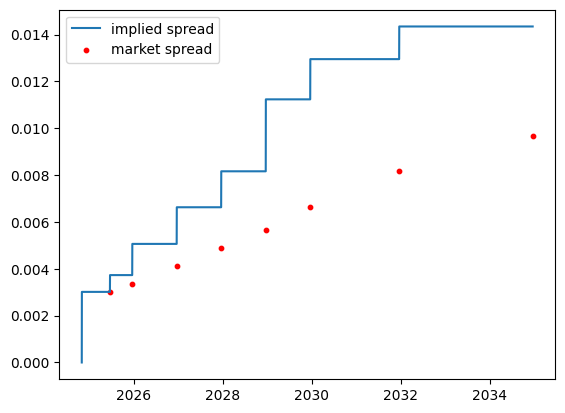

In [12]:
import matplotlib.pyplot as plt

dates = [Date.from_date(dt) for dt in pd.date_range("20241101", "20341220")]
curve_result = issuer_curve.print_table(dates)
curve_result.set_index("Date", inplace=True)
spread_dates = [Date(20,12,2024).add_tenor(tenor).datetime() for tenor in cds_data["Tenor"]]
spread_data = cds_data.copy()
spread_data["Date"] = spread_dates
del spread_data["Tenor"]
spread_data.set_index("Date", inplace=True)
spread_data /= 10000
implied_spread = curve_result["Hazard Rate"] * (1-0.4)

plt.plot(implied_spread, label="implied spread")
plt.scatter(spread_data.index, spread_data.Spread, label="market spread", color="red", s=10)
plt.legend()

In [43]:
def value(mat_date, spread):
    cds = GeneralCDS(settle_dt, mat_date, spread, notional=1e7)
    return cds.value(value_dt, issuer_curve, 0.4)["clean_pv"]

In [40]:
from scipy.optimize import newton

In [41]:
def par_spread(T):
    def obj(s):
        return value(T, s)
    return newton(obj, 1e-4)

In [49]:
implied_spread = [par_spread(dt) for dt in dates[1:]]

In [ ]:
implied_spread = pd.DataFrame(implied_spread, index=[dt.datetime() for dt in dates[1:]])
implied_spread.columns = ["Implied Spread"]

Text(0.5, 1.0, 'Market Quote vs Implied Spread')

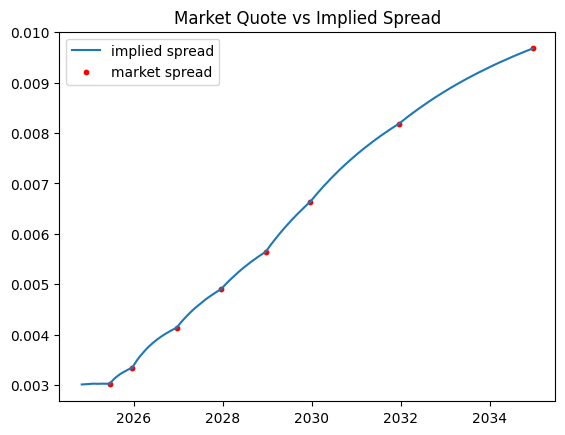

In [ ]:
plt.plot(implied_spread, label="implied spread")
plt.scatter(spread_data.index, spread_data.Spread, label="market spread", color="red", s=10)
plt.legend()
plt.title("Market Quote vs Implied Spread")